# Figure 2. c) analysis

This notebook replicates the per-complex evaluations from Fig. 2 c) and plots the resulting scatterplots and distributions.

In [1]:
import json
import numpy as np
import pandas as pd
import networkx as nx
from pathlib import Path
from typing import Dict
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

First we import the hierarchical clustering hyperparameters and corresponding adjusted mutual information scores for IntAct complexes from the Fig. 2 a) **module detection** analysis. The module detection analysis was run for 10 trials, so there are 10 sets of hyperparameters for each network/feature set.

In [2]:
with Path("../data/module-detection-cluster-parameters.json").open() as f:
    cluster_params = json.load(f)

# subset `cluster_params` to just IntAct
cluster_params = cluster_params["IntAct Complexes"]

# subset `cluster_params` to only include relevant networks and BIONIC, and only AMI related values
new_params = []
for dct in cluster_params:
    new_dct = {}
    for method, value in dct.items():
        value: Dict
        if method in ["Costanzo", "Hu", "Krogan", "BIONIC"]:
            new_dct[method] = {
                "AMI": value["AMI"],
                "AMI_params": value["AMI_params"]
            }
    new_params.append(new_dct)
cluster_params = new_params

Next, find and retain the trial for each network/features that corresponds to the highest AMI value achieved.

In [3]:
best_scores = {"Krogan": 0, "Hu": 0, "Costanzo": 0, "BIONIC": 0}
best_trial = {"Krogan": 0, "Hu": 0, "Costanzo": 0, "BIONIC": 0}

# find the best trial for each method
for trial, trial_dct in enumerate(cluster_params):
    trial: int
    trial_dct: Dict

    for method, value in trial_dct.items():
        ami = value["AMI"]
        if ami > best_scores[method]:
            best_scores[method] = ami
            best_trial[method] = trial

# extract the clustering hyperparameters corresponding to the best trial for each method
final_cluster_params = {}
for method, trial in best_trial.items():
    final_cluster_params[method] = cluster_params[trial][method]
cluster_params = final_cluster_params

print("Best clustering hyperparameters:")
cluster_params

Best clustering hyperparameters:


{'Krogan': {'AMI': 0.42087677639035864,
  'AMI_params': {'linkage': 'complete',
   'metric': 'precomputed',
   'threshold': 0.0}},
 'Hu': {'AMI': 0.06100276845100557,
  'AMI_params': {'linkage': 'average',
   'metric': 'precomputed',
   'threshold': 0.8438793133465128}},
 'Costanzo': {'AMI': 0.3753581653395252,
  'AMI_params': {'linkage': 'average',
   'metric': 'precomputed',
   'threshold': 0.812215717144763}},
 'BIONIC': {'AMI': 0.604954652055757,
  'AMI_params': {'linkage': 'single',
   'metric': 'cosine',
   'threshold': 0.8909391776430465}}}

Import the networks and features.

In [4]:
input_path = Path("../data/methods")

# import BIONIC features
features = pd.read_csv(input_path / "yeast_BIONIC_features.csv", index_col=0)

# import nets
net_names = ["Krogan-2006.txt", "Hu-2007.txt", "Costanzo-2016.txt"]
networks = {name.split("-")[0]: nx.read_weighted_edgelist(input_path / name) for name in net_names}

# convert networks to adjacency matrices
networks = {name: nx.to_pandas_adjacency(net) for name, net in networks.items()}

methods = networks
methods["BIONIC"] = features

Import IntAct protein complex standard.

In [5]:
input_path = Path("../data/standards")
with (input_path / "yeast-IntAct-complex-modules.json").open("r") as f:
    standard = json.load(f)

# show an example entry in the standard
standard['CPX-46']

['YLR438C-A', 'YNL147W', 'YER146W', 'YER112W', 'YDR378C', 'YBL026W']

Cluster the networks/features using the corresponding parameters in `cluster_params` and extract clusters at the given thresholds. Compare the resulting clusters with the complexes in `standard` and determine the best overlap score for each complex. The average overlap score across complexes for each method is reported. 

**NOTE:** This may take a few minutes to run.

In [6]:
final_scores = {}
final_clusters = {}

for method, data in methods.items():
    params = cluster_params[method]["AMI_params"]
    linkage_, metric, threshold = params["linkage"], params["metric"], params["threshold"]

    if metric == "precomputed":
        # transform similarity matrix to distance matrix
        X = data.max().max() - data
        np.fill_diagonal(X.values, 0)
        X = squareform(X.values)
    else:
        X = data.values

    # perform hierarchical clustering
    link = linkage(X, method=linkage_, metric=metric)

    # extract cluster labels
    cluster_labels = fcluster(link, threshold)

    # track overlap (jaccard) scores and best clusters for all complexes
    best_scores = []
    best_clusters = []

    # iterate over complexes in `standard`
    for complex, complex_genes in standard.items():

        # skip any "complexes" that are 2 members or less
        if len(complex_genes) <= 2:
            continue

        # track highest jaccard score and best cluster for the complex across all clusters
        best_score = 0
        best_cluster = None

        # get genes corresponding to labels for each cluster and compare to `complex`
        for idx in range(max(cluster_labels)):
            cluster_genes = set(data.index[np.argwhere(cluster_labels == idx).flatten()])
            if len(cluster_genes) == 0:
                continue

            # compute jaccard score numerator and denominator
            denom = len(cluster_genes.union(complex_genes))
            if denom == 0:
                continue
            numer = len(cluster_genes.intersection(complex_genes))
            if numer == 0:
                continue

            jaccard = numer / denom

            if jaccard > best_score:
                best_score = jaccard
                best_cluster = cluster_genes
        
        best_scores.append(best_score)
        best_clusters.append(best_cluster)
    
    final_scores[method] = best_scores
    final_clusters[method] = best_clusters

    print(f"Method: {method} \t Average Overlap Score: {np.mean(best_scores):.4f}")

Method: Krogan 	 Average Overlap Score: 0.3350
Method: Hu 	 Average Overlap Score: 0.1081
Method: Costanzo 	 Average Overlap Score: 0.3268
Method: BIONIC 	 Average Overlap Score: 0.4035


Determine number of "captured" complexes (i.e. complexes with an overlap score of 0.5 or greater) for each method.

In [7]:
for method, scores in final_scores.items():
    captured = [score for score in scores if score >= 0.5]
    print(f"Method: {method} \t Number of Captured Complexes: {len(captured)}")

Method: Krogan 	 Number of Captured Complexes: 88
Method: Hu 	 Number of Captured Complexes: 3
Method: Costanzo 	 Number of Captured Complexes: 74
Method: BIONIC 	 Number of Captured Complexes: 121


Create scatterplots and density plots to display the data.

<Figure size 432x288 with 0 Axes>

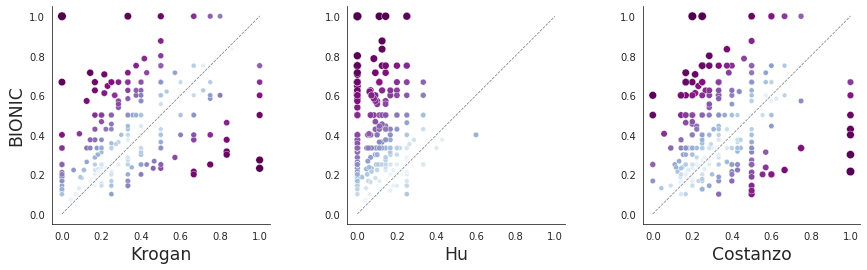

In [8]:
mpl.rcParams["axes.labelsize"] = "xx-large"
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["axes.titlesize"] = "xx-large"
mpl.rcParams["figure.titlesize"] = "xx-large"

plt.clf()

sns.set({"figure.facecolor": "white"})
sns.set_style("white")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
bionic_scores = final_scores["BIONIC"]

for idx, (net_name, ax) in enumerate(zip(["Krogan", "Hu", "Costanzo"], axes)):

    net_scores = final_scores[net_name]

    # compute difference (delta) between BIONIC complex scores and network complex scores
    delta = [
        np.abs(bionic_score - net_score) for bionic_score, net_score in zip(bionic_scores, net_scores)
    ]
    
    # plot scatterplot
    sns.scatterplot(
        x=net_scores,
        y=bionic_scores,
        ax=ax,
        hue=delta,
        size=delta,
        clip_on=False,
        palette=sns.color_palette("BuPu", n_colors=len(set(delta)))
    )
    ax.set_aspect("equal")

    # plot diagonal line
    ax.plot([0, 1], [0, 1], c=(0, 0, 0, 0.5), ls="--", lw=0.75)

    # remove legend
    legend = ax.get_legend()
    if legend:
        legend.remove()

    sns.despine()

    if idx == 0:
        ax.set_ylabel("BIONIC")
    ax.set_xlabel(net_name)

plt.show()

Plot the complex overlap score distribution for each method.

<Figure size 432x288 with 0 Axes>

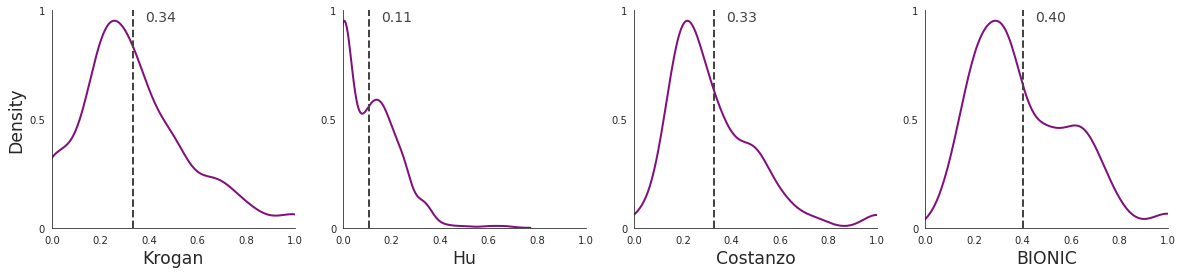

In [9]:
plt.clf()

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for idx, (method, ax) in enumerate(zip(["Krogan", "Hu", "Costanzo", "BIONIC"], axes)):
    
    # plot score distribution
    sns.kdeplot(
        x=final_scores[method],
        ax=ax,
        color="#810f7c",
    )

    # plot vertical line corresponding to average of score distribution
    avg_score = np.mean(final_scores[method])
    y_lim = ax.get_ylim()[1]
    ax.add_line(
        mpl.lines.Line2D(
            [avg_score, avg_score],
            [0, y_lim],
            lw=2,
            ls="--",
            color="#444444",
            axes=ax,
        )
    )

    # annotate line with the average score
    ax.text(
        avg_score + 0.05,  # shift x position of text so it's not too close to line
        y_lim,
        "{:0.2f}".format(avg_score),
        horizontalalignment="left",
        verticalalignment="top",
        fontsize=14,
        color="#444444",
    )
    ax.set_yticks([0, 0.5 * y_lim, y_lim])
    ax.set_yticklabels([0, 0.5, 1])
    ax.set_xlabel(method)
    ax.set_xlim(0, 1.0)

    if idx != 0:
        ax.set_ylabel("")

sns.despine()

plt.show()